In [2]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
from skimage import filters, color
from scipy.ndimage.filters import laplace
from utils import *

pictures_dir = "pictures"
setup = "SecretBeach"

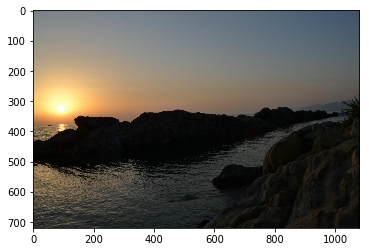

In [4]:
pic_path = os.path.join(pictures_dir, setup, setup + "1.jpg")
im = Image.open(pic_path)
plt.imshow(np.asarray(im));

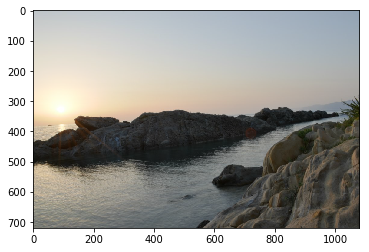

In [4]:
im = naive_average(load_images_from_path(pictures_dir, setup))
results_dir = "results"
output_path = os.path.join(results_dir, setup, "naive_merge.jpg")

if not os.path.exists(os.path.join(results_dir, setup)):
    os.mkdir(os.path.join(results_dir, setup ))

Image.fromarray(im).save(output_path)
plt.imshow(im);

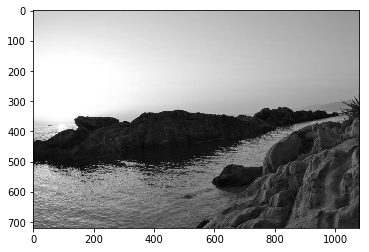

In [5]:
pic_path = os.path.join(pictures_dir, setup, setup + "2.jpg")
im = Image.open(pic_path)
im = np.asarray(im).astype(float)
im_gray = color.rgb2gray(im)
plt.imshow(im_gray, cmap="gray");

### Contrast: 
we apply a Laplacian filter to the grayscale version of each image, and take the absolute value of the filter response [16]. This yields a simple indicator C for contrast. It tends to assign a high weight to important elements such as edges and texture. A similar measure was used for multi-focus fusion for extended depth-of-field [19].

l'image est assez sale si on passe pas de gaussien avant mais d'après la suite de l'article:
"We could avoid sharp weight map transitions by smoothing the weight map with a Gaussian filter, but this results in undesirable halos around edges, and spills information across object boundaries"

In [6]:
np.max(contrast(im_gray))

C:\Users\Admin\AppData\Local\conda\conda\envs\exposure_fusion\lib\site-packages\skimage\restoration\uft.py:447: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  impr[([slice(1, 2)] * ndim)] = 2.0 * ndim


360.50289999999995

In [7]:
np.median(contrast(im_gray))

2.4250000000000114

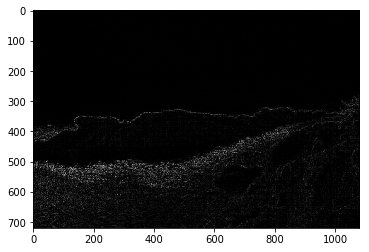

In [8]:
plt.imshow(normalize(contrast(im_gray)), cmap="gray");

### Saturation: 
As a photograph undergoes a longer exposure, the resulting colors become desaturated and eventually clipped. Saturated colors are desirable and make the image look vivid. We include a saturation measure S, which is computed as the standard deviation within the R, G and B channel, at each pixel.

la je capte pas trop. je pense que en chaque pixel on prend abs(f(x, couleur) - moyenne_globale(couleur)). et ensuite on additionne pour les 3 couleurs ?

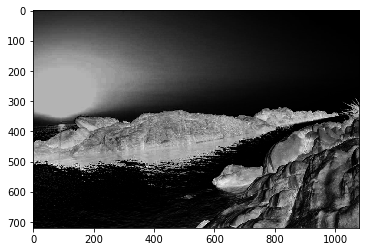

In [9]:
plt.imshow(normalize(saturation(im)), cmap="gray");

### Well-exposedness:
Looking at just the raw intensities within a channel, reveals how well a pixel is exposed.
We want to keep intensities that are not near zero (underexposed) or one (overexposed). We weight each intensity
i based on how close it is to 0.5 using a Gauss curve: exp 􀀀− (i−0.5)2
22 , where  equals 0.2 in our implementation.
To account for multiple color channels, we apply the Gauss curve to each channel separately, and multiply the results, yielding the measure E.

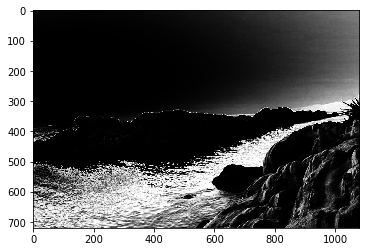

In [10]:
plt.imshow(normalize(exposure(im)), cmap="gray");

In [7]:
for i in range(1, 4):
    pic_path = os.path.join(pictures_dir, setup, setup + str(i) + ".jpg")
    im = Image.open(pic_path)
    im = np.asarray(im).astype(float)
    im_gray = color.rgb2gray(im)
    
    
    contrast_result = (normalize(contrast(im_gray)) * 255).astype("uint8")
    saturation_result = (normalize(saturation(im)) * 255).astype("uint8")
    exposure_result = (normalize(exposure(im)) * 255).astype("uint8")
    
    output_path = os.path.join(results_dir, setup, "contrast" + str(i) + ".jpg")
    Image.fromarray(contrast_result).convert("RGB").save(output_path)
    
    output_path = os.path.join(results_dir, setup, "saturation" + str(i) + ".jpg")
    Image.fromarray(saturation_result).convert("RGB").save(output_path)
    
    output_path = os.path.join(results_dir, setup, "exposure" + str(i) + ".jpg")
    Image.fromarray(exposure_result).convert("RGB").save(output_path)

### Weigth Map:

count:  8615


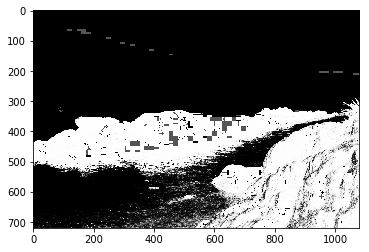

In [13]:
wms = []
sum_wm = None

for i in range(1, 4):
    setup = "SecretBeach"
    
    pic_path = os.path.join(pictures_dir, setup, setup + str(i) + ".jpg")
    im = Image.open(pic_path)
    im = np.asarray(im).astype(float)
    im_gray = color.rgb2gray(im)

    wm = weight_map(im, wc=1, we=1, ws=1)
    
    if sum_wm is None:
        sum_wm = wm.copy()
    else:
        sum_wm += wm
    wms.append(wm)
    
wms = np.array(wms)
wms = normalize_weight_map(wms)
        
for i in range(3):
    
    wm = (normalize(wms[i]) * 255).astype("uint8")

    output_path = os.path.join(results_dir, setup, "weight_map" + str(i + 1) + ".jpg")
    Image.fromarray(wm).convert("RGB").save(output_path)

    plt.imshow(wm, cmap="gray");

count:  8615


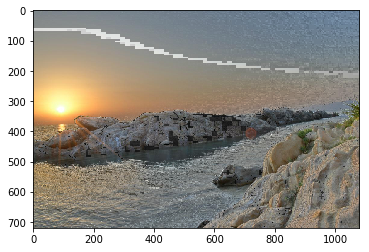

In [11]:
# cf figure 4.b dans le papier
images = load_images_from_path(pictures_dir, setup)
merged = eq1(images)

output_path = os.path.join(results_dir, setup, "wm_direct_merge.jpg")
Image.fromarray(merged).save(output_path)

plt.imshow(merged);

count:  0


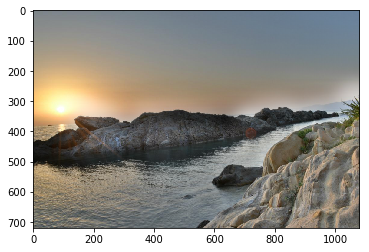

In [13]:
# cf figure 4.c dans le papier
images = load_images_from_path(pictures_dir, setup)
merged = eq1(images, blur=True, sigma=30.)
output_path = os.path.join(results_dir, setup, "wm_direct_merge_sigma=" + str(sigma) + ".jpg")
Image.fromarray(merged).save(output_path)
plt.imshow(merged);

In [ ]:
del images
del merged
del wm
del im

### An edge-aware smoothing operation using the cross-bilateral filter seems like a better alternative [22, 9]. However, it is unclear how to define the control image, which would tell us where the smoothing should be stopped. Using the original grayscale image as control image does not work well, as demonstrated in Fig. 4d
A faire ?

Pour les pyramides la: ce que j'ai compris c'est que tu appliques un filtre gaussian 5*5 plusieurs fois sur l'image. Ca te donne ta pyramide gaussienne. Ensuite la différence entre chaque niveau de la pyramide gaussienne c'est ta pyramide de Laplace. Et voila. Ya une fonction de cv2 qui le fait mais elle rend les images + petites (c'est ce qu'on entend en général par pyramide gaussienne, mais bon la on préfère garder les tailles initiales, ca sera bien + simples donc pas la peine de prendre opencv)


Note: on est obligés de clipper car les valeurs sont pas entre 0 et 255... Il faudrait faire une normalisation robuste

In [5]:
n = 7
sigma = 30
wc = 1
we = 1
ws = 1

from utils import percentage_outofbound

C:\Users\Admin\AppData\Local\conda\conda\envs\exposure_fusion\lib\site-packages\skimage\restoration\uft.py:447: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  impr[([slice(1, 2)] * ndim)] = 2.0 * ndim


count:  0
0


C:\Users\Admin\AppData\Local\conda\conda\envs\exposure_fusion\lib\site-packages\skimage\filters\_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


1
2
percentage of pixels out of bound: 0.030689300411522635
max:  336.49452958111317
min:  -48.11871881614579


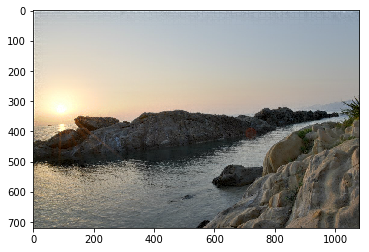

count:  0
0
1
2
percentage of pixels out of bound: 0.02533179012345679
max:  290.4690412275276
min:  -48.847463281714596


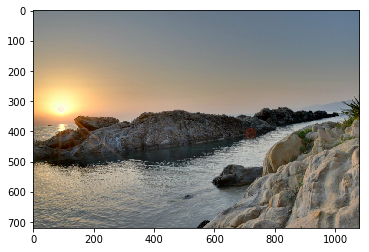

count:  8615
0
1
2
percentage of pixels out of bound: 0.031613940329218104
max:  288.3066614853234
min:  -38.787624854663896


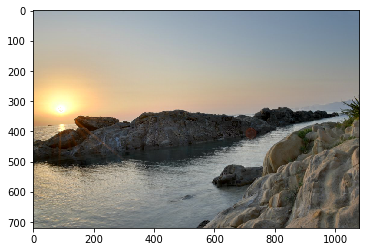

count:  8615
0
1
2
percentage of pixels out of bound: 0.02949074074074074
max:  294.38637471509827
min:  -48.83085572737751


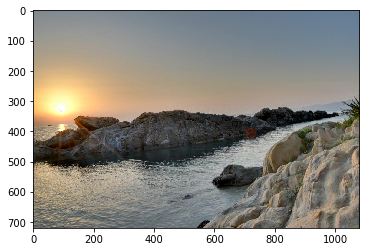

In [6]:
wcs = [1, 0, 0, 1]
wes = [0, 1, 0, 1]
wss = [0, 0, 1, 1]

for i in range(4):
    
    wc = wcs[i]
    we = wes[i]
    ws = wss[i]

    product = pyramid_merge_low_ram(pictures_dir, setup, wc=wc, we=we, ws=ws, sigma=sigma, n=n)
    print("percentage of pixels out of bound:", percentage_outofbound(product) * 100)
    print("max: ", np.max(product))
    print("min: ", np.min(product))
    plt.imshow(np.clip(product, 0, 255).astype("uint8"))
    plt.show()

    result = np.clip(product, 0, 255)
    result = result.astype("uint8")
    result = Image.fromarray(result, 'RGB')
    result_name = setup + "_"
    result_name += "n="+str(n)
    result_name += "sigma="+str(sigma)
    result_name += "we="+str(we)
    result_name += "wc="+str(wc)
    result_name += "ws="+str(ws)

    results_dir = "results"
    if not os.path.exists(os.path.join(results_dir, setup)):
        os.mkdir(os.path.join(results_dir, setup))

    result.save(os.path.join(results_dir, setup, result_name + ".jpg"))

count:  8615
0
1
2
percentage of pixels out of bound: 1.2393261316872428
max:  293.96966169549034
min:  -38.81577323028279


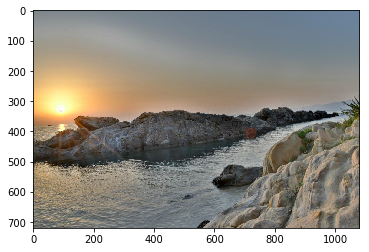

count:  8615
0
1
2
percentage of pixels out of bound: 1.7148919753086418
max:  295.4647394558612
min:  -42.57464924805221


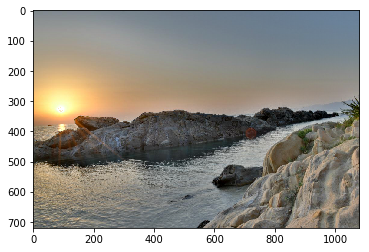

count:  8615
0
1
2
percentage of pixels out of bound: 2.0416666666666665
max:  295.6614044767611
min:  -45.02750940631354


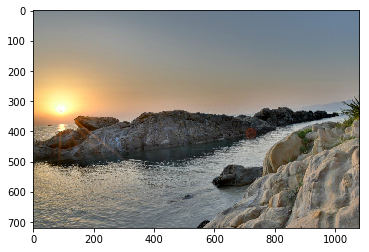

count:  8615
0
1
2
percentage of pixels out of bound: 2.3870884773662553
max:  295.346214329689
min:  -46.72579489334656


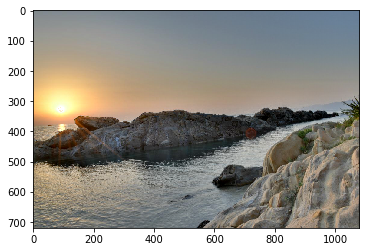

count:  8615
0
1
2
percentage of pixels out of bound: 2.679398148148148
max:  294.87703796657075
min:  -47.92284520847181


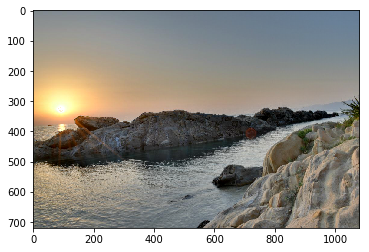

count:  8615
0
1
2
percentage of pixels out of bound: 2.949074074074074
max:  294.38637471509827
min:  -48.83085572737751


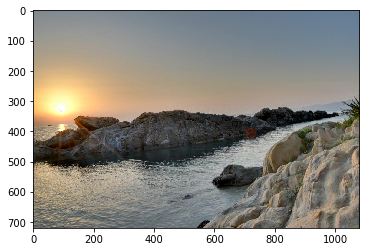

In [14]:
ns = [2, 3, 4, 5, 6, 7]

wc = 1
we = 1
ws = 1

for i in range(len(ns)):
    n = ns[i]

    product = pyramid_merge_low_ram(pictures_dir, setup, wc=wc, we=we, ws=ws, sigma=sigma, n=n)
    print("percentage of pixels out of bound:", percentage_outofbound(product) * 100)
    print("max: ", np.max(product))
    print("min: ", np.min(product))
    plt.imshow(np.clip(product, 0, 255).astype("uint8"))
    plt.show()

    result = np.clip(product, 0, 255)
    result = result.astype("uint8")
    result = Image.fromarray(result, 'RGB')
    result_name = setup + "_"
    result_name += "n="+str(n)
    result_name += "sigma="+str(sigma)
    result_name += "we="+str(we)
    result_name += "wc="+str(wc)
    result_name += "ws="+str(ws)

    results_dir = "results"
    if not os.path.exists(os.path.join(results_dir, setup)):
        os.mkdir(os.path.join(results_dir, setup))

    result.save(os.path.join(results_dir, setup, result_name + ".jpg"))

count:  0
0
1
2
percentage of pixels out of bound: 0.9777520576131687
max:  288.1822010719861
min:  -35.32478086747675


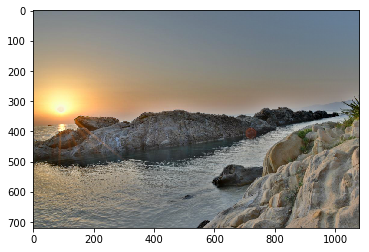

count:  0
0
1
2
percentage of pixels out of bound: 1.2779063786008231
max:  290.7451919455531
min:  -41.22463899554029


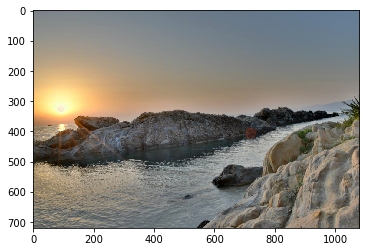

count:  0
0
1
2
percentage of pixels out of bound: 1.6156121399176955
max:  291.35757916048794
min:  -44.318946975693564


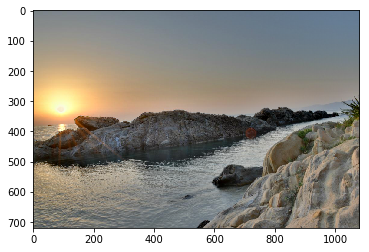

count:  0
0
1
2
percentage of pixels out of bound: 1.9489454732510287
max:  291.2464839768989
min:  -46.376947879673466


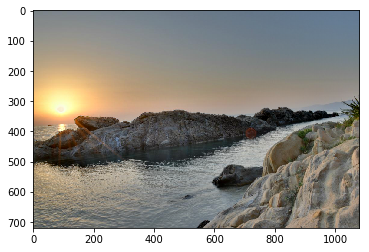

count:  0
0
1
2
percentage of pixels out of bound: 2.2699331275720165
max:  290.8907136153906
min:  -47.79895583593334


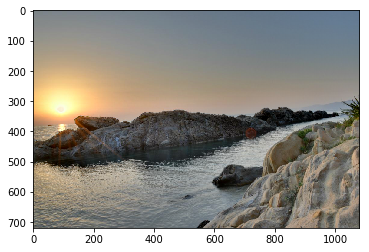

count:  0
0
1
2
percentage of pixels out of bound: 2.5331790123456788
max:  290.4690412275276
min:  -48.847463281714596


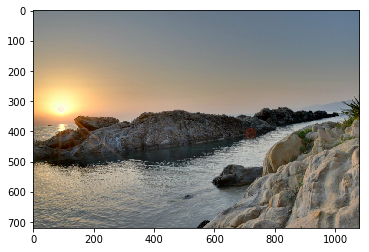

In [14]:
ns = [2, 3, 4, 5, 6, 7]

wc = 0
we = 1
ws = 0

for i in range(len(ns)):
    n = ns[i]

    product = pyramid_merge_low_ram(pictures_dir, setup, wc=wc, we=we, ws=ws, sigma=sigma, n=n)
    print("percentage of pixels out of bound:", percentage_outofbound(product) * 100)
    print("max: ", np.max(product))
    print("min: ", np.min(product))
    plt.imshow(np.clip(product, 0, 255).astype("uint8"))
    plt.show()

    result = np.clip(product, 0, 255)
    result = result.astype("uint8")
    result = Image.fromarray(result, 'RGB')
    result_name = setup + "_"
    result_name += "n="+str(n)
    result_name += "sigma="+str(sigma)
    result_name += "we="+str(we)
    result_name += "wc="+str(wc)
    result_name += "ws="+str(ws)

    results_dir = "results"
    if not os.path.exists(os.path.join(results_dir, setup)):
        os.mkdir(os.path.join(results_dir, setup))

    result.save(os.path.join(results_dir, setup, result_name + ".jpg"))

In [15]:
n = 4  # 4 c'est suffisant normalement

## Me vs HDR:

count:  3808
0
1
2
3
4
5
6
percentage of pixels out of bound: 1.3448994602436564
max:  347.95896870420825
min:  -89.33731910665796


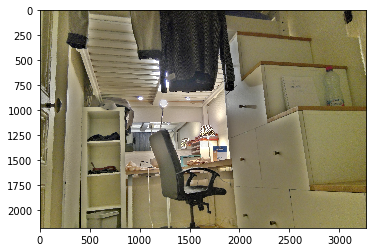

In [16]:
pictures_dir = "pictures"
setup = "me_vs_hdr"
    
n = 4
wc = 1
we = 1
ws = 1

product = pyramid_merge_low_ram(pictures_dir, setup, wc=wc, we=we, ws=ws, sigma=sigma, n=n)
print("percentage of pixels out of bound:", percentage_outofbound(product) * 100)
print("max: ", np.max(product))
print("min: ", np.min(product))
plt.imshow(np.clip(product, 0, 255).astype("uint8"))
plt.show()

result = np.clip(product, 0, 255)
result = result.astype("uint8")
result = Image.fromarray(result, 'RGB')
result_name = setup + "_"
result_name += "n="+str(n)
result_name += "sigma="+str(sigma)
result_name += "we="+str(we)
result_name += "wc="+str(wc)
result_name += "ws="+str(ws)

results_dir = "results"
if not os.path.exists(os.path.join(results_dir, setup)):
    os.mkdir(os.path.join(results_dir, setup))

result.save(os.path.join(results_dir, setup, result_name + ".jpg"))

## influence du nombre d'images:

count:  225096
0
1
percentage of pixels out of bound: 5.992596372188581
max:  300.5371888196754
min:  -35.309615754819674


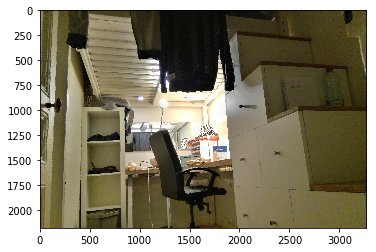

count:  44232
0
1
percentage of pixels out of bound: 2.7323334549812572
max:  344.74466750147917
min:  -97.55569933526715


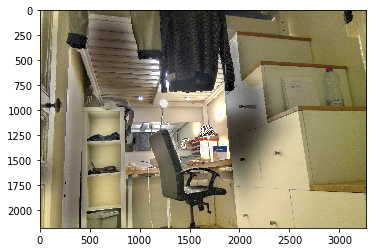

count:  18604
0
1
2
percentage of pixels out of bound: 3.0066467073961936
max:  342.23798126918336
min:  -96.379555779006


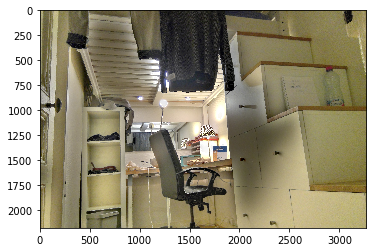

In [15]:
# on vient de faire avec 6, mtn on test avec 2 et avec 3:

pictures_dir = "pictures"

for setup in ["only_2_pictures_middle", "only_2_pictures", "only_3_pictures"]:

    n = 8
    wc = 1
    we = 1
    ws = 1

    product = pyramid_merge_low_ram(pictures_dir, setup, wc=wc, we=we, ws=ws, sigma=sigma, n=n)
    print("percentage of pixels out of bound:", percentage_outofbound(product) * 100)
    print("max: ", np.max(product))
    print("min: ", np.min(product))
    plt.imshow(np.clip(product, 0, 255).astype("uint8"))
    plt.show()

    result = np.clip(product, 0, 255)
    result = result.astype("uint8")
    result = Image.fromarray(result, 'RGB')
    result_name = setup + "_"
    result_name += "n="+str(n)
    result_name += "sigma="+str(sigma)
    result_name += "we="+str(we)
    result_name += "wc="+str(wc)
    result_name += "ws="+str(ws)

    results_dir = "results"
    if not os.path.exists(os.path.join(results_dir, setup)):
        os.mkdir(os.path.join(results_dir, setup))

    result.save(os.path.join(results_dir, setup, result_name + ".jpg"))

## flash no flash

C:\Users\Admin\AppData\Local\conda\conda\envs\exposure_fusion\lib\site-packages\skimage\restoration\uft.py:447: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  impr[([slice(1, 2)] * ndim)] = 2.0 * ndim


count:  37637
0


C:\Users\Admin\AppData\Local\conda\conda\envs\exposure_fusion\lib\site-packages\skimage\filters\_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


1
percentage of pixels out of bound: 2.7058783461617057
max:  307.25287301707607
min:  -52.57105899907222


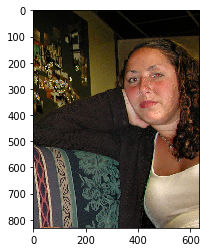

In [4]:
# on vient de faire avec 6, mtn on test avec 2 et avec 3:

pictures_dir = "pictures"
setup = "esther_flash_no_flash"

n = 8
wc = 1
we = 1
ws = 1
sigma = 30

product = pyramid_merge_low_ram(pictures_dir, setup, wc=wc, we=we, ws=ws, sigma=sigma, n=n)
print("percentage of pixels out of bound:", percentage_outofbound(product) * 100)
print("max: ", np.max(product))
print("min: ", np.min(product))
plt.imshow(np.clip(product, 0, 255).astype("uint8"))
plt.show()

result = np.clip(product, 0, 255)
result = result.astype("uint8")
result = Image.fromarray(result, 'RGB')
result_name = setup + "_"
result_name += "n="+str(n)
result_name += "sigma="+str(sigma)
result_name += "we="+str(we)
result_name += "wc="+str(wc)
result_name += "ws="+str(ws)

results_dir = "results"
if not os.path.exists(os.path.join(results_dir, setup)):
    os.mkdir(os.path.join(results_dir, setup))

result.save(os.path.join(results_dir, setup, result_name + ".jpg"))

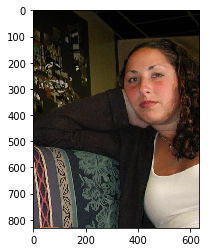

In [23]:
im = naive_average(load_images_from_path(pictures_dir, setup))
results_dir = "results"
output_path = os.path.join(results_dir, setup, "naive_merge.jpg")

if not os.path.exists(os.path.join(results_dir, setup)):
    os.mkdir(os.path.join(results_dir, setup ))

Image.fromarray(im).save(output_path)
plt.imshow(im);